<a href="https://colab.research.google.com/github/aparnagithb/Bharat-Internship-2024/blob/master/model/Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)

In [ ]:
df=pd.read_csv("Bengaluru_House_Data.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [ ]:
df['bath'].quantile(0.7) +df['bath']


0        5.0
1        8.0
2        5.0
3        6.0
4        5.0
        ... 
13315    7.0
13316    8.0
13317    5.0
13318    7.0
13319    4.0
Name: bath, Length: 13320, dtype: float64

In [ ]:
df2=df.drop(['area_type', 'availability', 'society','balcony'], axis='columns')
df3=df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [ ]:
df3['bhk']=df3['size'].apply(lambda x: int(x.split()[0]))

<ipython-input-5-b95d179482ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk']=df3['size'].apply(lambda x: int(x.split()[0]))


In [ ]:
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [ ]:
df3.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [ ]:
def convert_tofloat(x):
  tokens=x.split("-")
  if len(tokens)==2:
    return ((float(tokens[0])+float(tokens[1]))/2)
  try:
    return float(x)
  except :
    return None


In [ ]:
df4=df3.copy()
df4['total_sqft']=df4['total_sqft'].apply(convert_tofloat)
df4.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [ ]:
df5=df4.copy()
df5['price_per_sqft']=df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [ ]:
df5.location=df5.location.apply(lambda  x: x.strip())
location_stats = df5.groupby('location')['location'].agg('count').sort_values(ascending=True)
location_stats_lessthan10=location_stats[location_stats<=10]
#df5.groupby('location')['location'].agg('count') this gives a series object where index is city and value is count

In [ ]:
df5.location=df5.location.apply(lambda x:'other' if x in location_stats_lessthan10 else x )
len(df5.location.unique())


242

In [ ]:
df6=df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12502, 7)

In [ ]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [ ]:
df6.groupby('location')['location'].count()

location
1st Block Jayanagar            10
1st Phase JP Nagar             24
2nd Phase Judicial Layout      11
2nd Stage Nagarbhavi            9
5th Block Hbr Layout            7
                             ... 
Yelahanka                     205
Yelahanka New Town             39
Yelenahalli                    13
Yeshwanthpur                   80
other                        2569
Name: location, Length: 242, dtype: int64

In [ ]:
def remove_pps_outliers(df):
  df_out=pd.DataFrame()
  for key, subdf in df.groupby('location'):
    m=np.mean(subdf.price_per_sqft)
    st=np.std(subdf.price_per_sqft)
    reduced=subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
    df_out=pd.concat([df_out, reduced], ignore_index=True)
  return df_out
df7=remove_pps_outliers(df6)
df7.shape

(10241, 7)

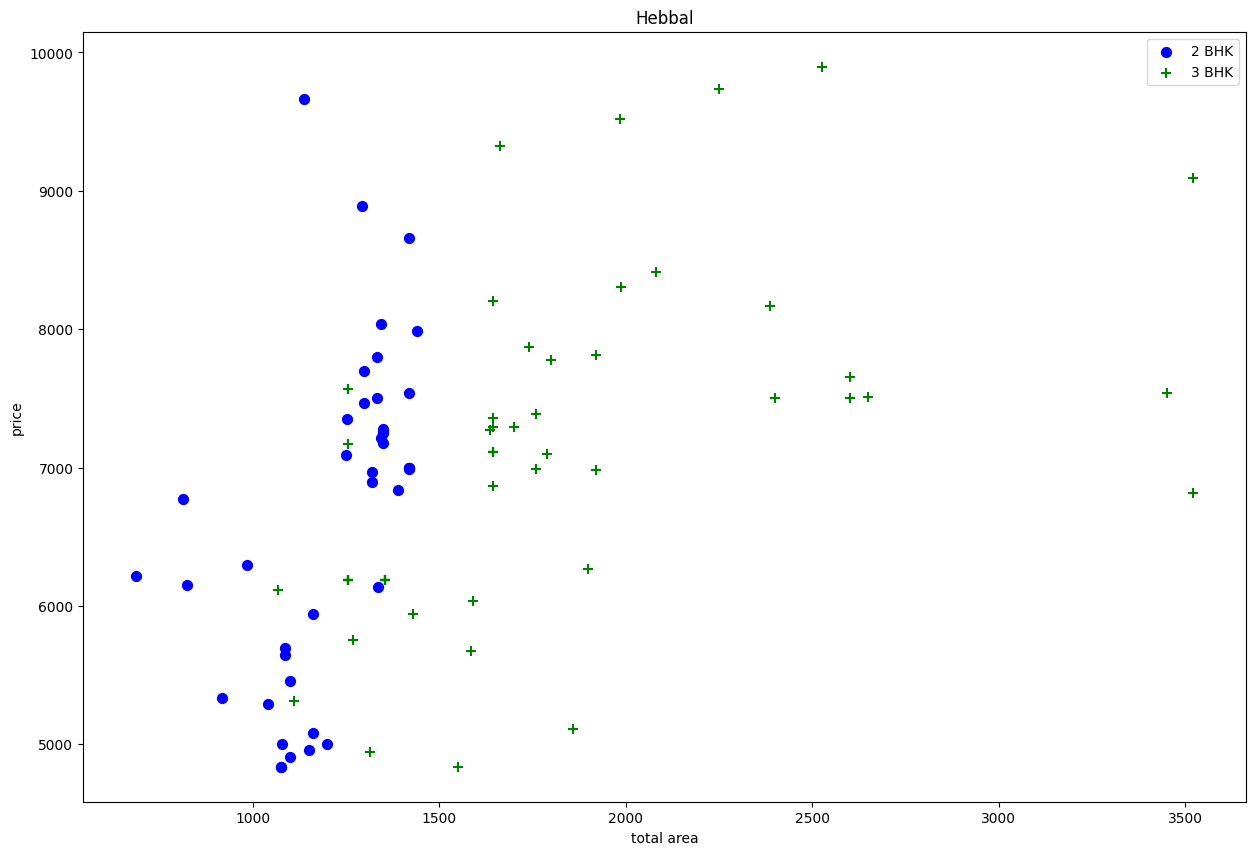

In [ ]:
def plot_scatter_chart(df, location):
  bh2=df[(df.location==location) &(df.bhk==2)]
  bh3=df[(df.location==location) &(df.bhk==3)]
  matplotlib.rcParams['figure.figsize']=(15,10)
  plt.scatter(bh2.total_sqft, bh2.price_per_sqft, color='blue', label='2 BHK', s=50)
  plt.scatter(bh3.total_sqft, bh3.price_per_sqft,marker='+', color='green', label='3 BHK', s=50)
  plt.xlabel("total area")
  plt.ylabel("price")
  plt.title(location)
  plt.legend()
plot_scatter_chart(df7 ,"Hebbal")#blue is 2 bhk but price hgiher than 3 bhk so outlier

In [ ]:
def remove_bhk_outlier(df):
  exclude_indices=np.array([])
  for locations , location_df in df.groupby('location'):
    bhk_stats={}
    for bhk , bhk_df in location_df.groupby('bhk'):
      bhk_stats[bhk]={
          'mean':np.mean(bhk_df.price_per_sqft),
          'std':np.std(bhk_df.price_per_sqft),
          'count':bhk_df.shape[0]
      }
    for bhk , bhk_df in location_df.groupby('bhk'):
      stats=bhk_stats.get(bhk-1)
      if stats and stats['count']>5 :
        exclude_indices=np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
  return df.drop(exclude_indices, axis='index')
df8=remove_bhk_outlier(df7)
df8.shape


(7329, 7)

Text(0, 0.5, 'count')

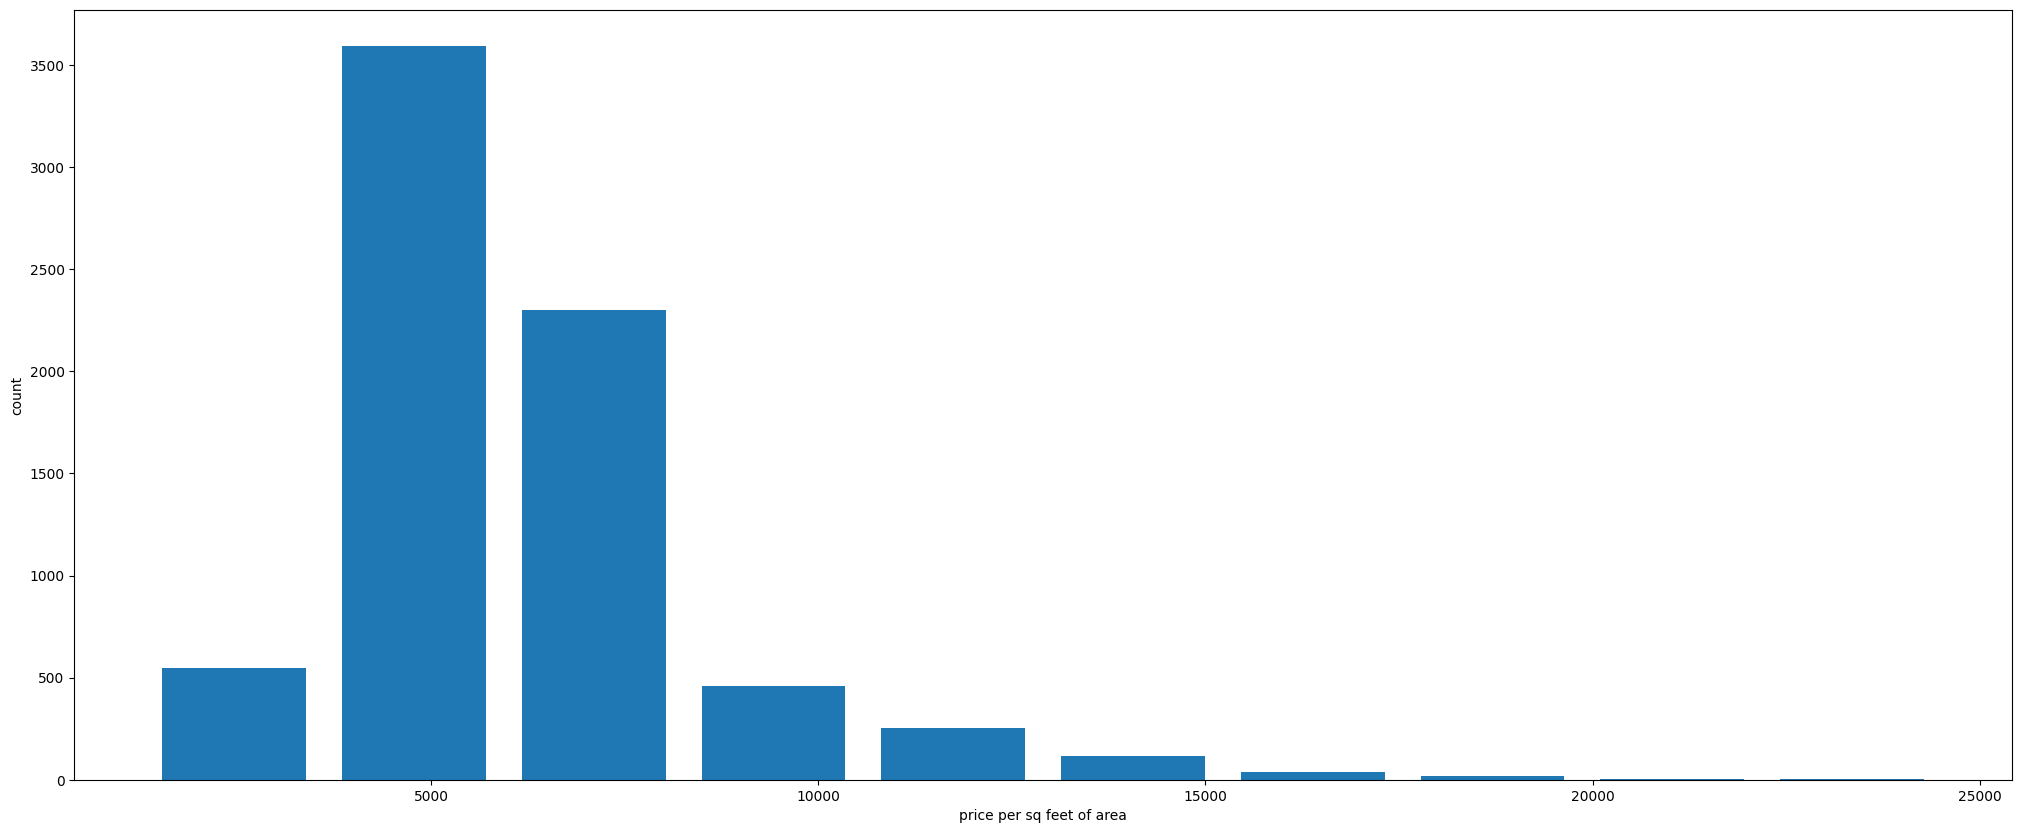

In [ ]:
#histogram -no of data points in a category
matplotlib.rcParams['figure.figsize']=(25,10)
plt.hist(df8.price_per_sqft, rwidth=0.8)
plt.xlabel("price per sq feet of area")
plt.ylabel("count")

In [ ]:
df9=df8[df8.bath<df8.bhk+2]#drop rows where there are more bathrooms than bedrooms
df10=df9.drop(['price_per_sqft', 'size'], axis='columns')#drop columns which were only create for outlier detection

In [ ]:
dummies =pd.get_dummies(df10.location)#one hot encoding, like a meansa will be 1 all other than a will be 0
df11=pd.concat([df10, dummies.drop('other', axis='columns')], axis='columns')#drop a column to escape from trap
df11.drop('location', axis='columns', inplace=True)
df11.head()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X=df11.drop('price', axis='columns')#training data
Y=df11.price#target
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  LinearRegression
X_train , X_test , Y_train ,Y_test=train_test_split(X,Y,test_size=0.2, random_state=10)
lr_clf=LinearRegression()
lr_clf.fit(X_train , Y_train)
lr_clf.score(X_test, Y_test)



0.8452277697874376

In [ ]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)#to mix up or randomis
cross_val_score(LinearRegression(), X, Y, cv=cv)



array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
def perform_grid_search_and_return_results_for_best_model(X, y):
  models = {
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [ 1, 2],
            'selection': ['cyclic', 'random']  # 'selection' -what gradeint descent algo used to train
        }
    },
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(),
        'params': {
            'criterion': ['squared_error', 'friedman_mse'],  # 'criterion' -function to check quality of a split
            'splitter': ['best', 'random']  #  'splitter' -what to take based on criteria
        }
    },
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
           # 'normalize': [True, False]#whether to normalise data beforer training or not
        }
    }
  }
  results=[]
  cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0 ) #to mix up or randomis


  for model_name, model_info in models.items():
    grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=cv,return_train_score=False)
    grid_search.fit(X,y)
    result_entry = {
        'Model': model_name,
        'Best Score': grid_search.best_score_,
        'Best Params': grid_search.best_params_
    }
    results.append(result_entry)
  return pd.DataFrame(results)

perform_grid_search_and_return_results_for_best_model(X,Y)

,Model,Best Score,Best Params
0,Lasso,0.687503,"{'alpha': 1, 'selection': 'random'}"
1,DecisionTreeRegressor,0.749853,"{'criterion': 'squared_error', 'splitter': 'ra..."
2,LinearRegression,0.818354,{}


In [ ]:
X.columns
 #like jayanagar is loc_index 4

Index(['total_sqft', 'bath', 'bhk', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       '6th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=244)

In [ ]:
np.where(X.columns=='Whitefield')


(array([238]),)

In [ ]:
def predictprice(location, sqft, bath , bhk):
  loc_index=np.where(X.columns==location)[0][0]
  x=np.zeros(len(X.columns))
  x[0]=sqft
  x[1]=bath
  x[2]=bhk
  if loc_index>=0:
    x[loc_index]=1
  return lr_clf.predict([x])[0]
predictprice('1st Phase JP Nagar', 1000,2,2)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


83.49904677206221

In [ ]:
import pickle
with open('price_prediction_model.pkl', 'wb') as file:
  pickle.dump(lr_clf , file)

In [ ]:
import json
columns={
    'data_columns':[col.lower() for col in X.columns]#only all column names
}
with open('columns.json', 'w') as f:
  f.write(json.dumps(columns))